# Model Experiments
Testing multiple architectures on a subset of training data

## Import Dependencies

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models
from PIL import Image
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import random
from tqdm import tqdm

## Define Constants

In [3]:
# Paths
TRAIN_DIR = Path('data/train')
EXPERIMENTS_DIR = Path('data/experiments')

# Training parameters
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
IMG_SIZE = 224
VAL_SPLIT = 0.2
EXPERIMENT_SAMPLE_SIZE = 0.2  # 20% of training data

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Class names
CLASS_NAMES = ['healthy', 'multiple_diseases', 'rust', 'scab']
NUM_CLASSES = len(CLASS_NAMES)

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## Create Experiments Dataset
Copy 20% of images from each class in train to experiments folder

In [4]:
# Create experiments directory if it doesn't exist
if not EXPERIMENTS_DIR.exists():
    EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Created experiments directory: {EXPERIMENTS_DIR}')
    
    # Copy 20% of images from each class to experiments
    for class_name in CLASS_NAMES:
        train_class_dir = TRAIN_DIR / class_name
        exp_class_dir = EXPERIMENTS_DIR / class_name
        exp_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Get all images in this class
        all_images = list(train_class_dir.glob('*.jpg'))
        
        # Calculate number of images to copy (20%)
        num_exp = int(len(all_images) * EXPERIMENT_SAMPLE_SIZE)
        
        # Randomly select images for experiments
        exp_images = random.sample(all_images, num_exp)
        
        # Copy images to experiments folder
        for img_path in exp_images:
            dest_path = exp_class_dir / img_path.name
            shutil.copy2(str(img_path), str(dest_path))
        
        print(f'{class_name}: Copied {num_exp} images to experiments ({len(all_images)} total in train)')
    
    print(f'\nExperiments dataset created successfully!')
else:
    print(f'Experiments directory already exists: {EXPERIMENTS_DIR}')
    # Show experiments set statistics
    for class_name in CLASS_NAMES:
        exp_class_dir = EXPERIMENTS_DIR / class_name
        if exp_class_dir.exists():
            num_exp_images = len(list(exp_class_dir.glob('*.jpg')))
            print(f'{class_name}: {num_exp_images} experiment images')

Created experiments directory: data\experiments
healthy: Copied 93 images to experiments (465 total in train)
multiple_diseases: Copied 16 images to experiments (81 total in train)
rust: Copied 112 images to experiments (560 total in train)
scab: Copied 106 images to experiments (532 total in train)

Experiments dataset created successfully!


## Image Generators
Using experiments folder as training set with 20% validation split

In [5]:
class PlantPathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare experiment data
exp_image_paths = []
exp_labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = EXPERIMENTS_DIR / class_name
    for img_path in class_dir.glob('*.jpg'):
        exp_image_paths.append(str(img_path))
        exp_labels.append(class_idx)

print(f'Experiment images: {len(exp_image_paths)}')

# Split into train and validation (20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    exp_image_paths, exp_labels, test_size=VAL_SPLIT, random_state=42, stratify=exp_labels
)

print(f'Train split: {len(train_paths)}')
print(f'Validation split: {len(val_paths)}')

# Create datasets
train_dataset = PlantPathologyDataset(train_paths, train_labels, train_transform)
val_dataset = PlantPathologyDataset(val_paths, val_labels, val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Created dataloaders: train={len(train_loader)} batches, val={len(val_loader)} batches')

Experiment images: 327
Train split: 261
Validation split: 66
Created dataloaders: train=9 batches, val=3 batches


## Training Functions

In [6]:
def train_model(model, model_name, train_loader, val_loader, epochs, device):
    """
    Train a model and log results to tensorboard
    """
    # Setup tensorboard writer
    writer = SummaryWriter(f'runs/{model_name}')
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 50)
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation'):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Log to tensorboard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, f'best_{model_name}.pth')
            print(f'Best model saved with validation accuracy: {val_acc:.2f}%')
    
    writer.close()
    print(f'\n{model_name} training completed! Best validation accuracy: {best_val_acc:.2f}%')
    return best_val_acc

## Model 1: ResNet50

In [7]:
print('\n' + '='*70)
print('Training ResNet50')
print('='*70)

# Load pretrained ResNet50
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers
for param in resnet50.parameters():
    param.requires_grad = False

# Replace classifier
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, NUM_CLASSES)
)

resnet50 = resnet50.to(DEVICE)
print(f'ResNet50 loaded and moved to {DEVICE}')

# Train
resnet50_acc = train_model(resnet50, 'ResNet50', train_loader, val_loader, EPOCHS, DEVICE)


Training ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Paula/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 12.8MB/s]


ResNet50 loaded and moved to cuda

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Train Loss: 1.2908, Train Acc: 36.40%
Val Loss: 1.0751, Val Acc: 53.03%
Best model saved with validation accuracy: 53.03%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Train Loss: 1.1318, Train Acc: 49.04%
Val Loss: 1.1614, Val Acc: 57.58%
Best model saved with validation accuracy: 57.58%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Train Loss: 0.9541, Train Acc: 65.13%
Val Loss: 0.8751, Val Acc: 66.67%
Best model saved with validation accuracy: 66.67%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Train Loss: 0.9372, Train Acc: 70.11%
Val Loss: 0.8820, Val Acc: 78.79%
Best model saved with validation accuracy: 78.79%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


Train Loss: 0.8391, Train Acc: 74.71%
Val Loss: 0.7965, Val Acc: 81.82%
Best model saved with validation accuracy: 81.82%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Train Loss: 0.7257, Train Acc: 75.86%
Val Loss: 0.7588, Val Acc: 81.82%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


Train Loss: 0.7318, Train Acc: 77.78%
Val Loss: 0.6929, Val Acc: 84.85%
Best model saved with validation accuracy: 84.85%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Train Loss: 0.7411, Train Acc: 78.16%
Val Loss: 0.6757, Val Acc: 84.85%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Train Loss: 0.6643, Train Acc: 77.78%
Val Loss: 0.6610, Val Acc: 83.33%

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

Train Loss: 0.6890, Train Acc: 77.39%
Val Loss: 0.6722, Val Acc: 81.82%

ResNet50 training completed! Best validation accuracy: 84.85%


## Model 2: EfficientNet-B1

In [8]:
print('\n' + '='*70)
print('Training EfficientNet-B1')
print('='*70)

# Load pretrained EfficientNet-B1
efficientnet_b1 = models.efficientnet_b1(pretrained=True)

# Freeze all layers
for param in efficientnet_b1.parameters():
    param.requires_grad = False

# Replace classifier
num_features = efficientnet_b1.classifier[1].in_features
efficientnet_b1.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, NUM_CLASSES)
)

efficientnet_b1 = efficientnet_b1.to(DEVICE)
print(f'EfficientNet-B1 loaded and moved to {DEVICE}')

# Train
efficientnet_b1_acc = train_model(efficientnet_b1, 'EfficientNet-B1', train_loader, val_loader, EPOCHS, DEVICE)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to C:\Users\Paula/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-533bc792.pth



Training EfficientNet-B1


100%|██████████| 30.1M/30.1M [00:02<00:00, 10.6MB/s]


EfficientNet-B1 loaded and moved to cuda

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Train Loss: 1.2474, Train Acc: 38.31%
Val Loss: 1.0986, Val Acc: 63.64%
Best model saved with validation accuracy: 63.64%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Train Loss: 1.1095, Train Acc: 55.17%
Val Loss: 1.0164, Val Acc: 71.21%
Best model saved with validation accuracy: 71.21%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Train Loss: 1.0045, Train Acc: 66.28%
Val Loss: 0.9973, Val Acc: 63.64%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Train Loss: 0.9711, Train Acc: 68.20%
Val Loss: 0.9935, Val Acc: 62.12%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Train Loss: 0.9040, Train Acc: 70.11%
Val Loss: 0.9510, Val Acc: 65.15%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Train Loss: 0.8505, Train Acc: 70.88%
Val Loss: 0.9416, Val Acc: 65.15%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Train Loss: 0.8155, Train Acc: 70.11%
Val Loss: 0.9246, Val Acc: 63.64%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Train Loss: 0.7642, Train Acc: 72.41%
Val Loss: 0.9214, Val Acc: 65.15%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Train Loss: 0.7605, Train Acc: 70.11%
Val Loss: 0.8987, Val Acc: 65.15%

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

Train Loss: 0.7178, Train Acc: 76.25%
Val Loss: 0.8849, Val Acc: 65.15%

EfficientNet-B1 training completed! Best validation accuracy: 71.21%


## Model 3: EfficientNet-B2

In [9]:
print('\n' + '='*70)
print('Training EfficientNet-B2')
print('='*70)

# Load pretrained EfficientNet-B2
efficientnet_b2 = models.efficientnet_b2(pretrained=True)

# Freeze all layers
for param in efficientnet_b2.parameters():
    param.requires_grad = False

# Replace classifier
num_features = efficientnet_b2.classifier[1].in_features
efficientnet_b2.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, NUM_CLASSES)
)

efficientnet_b2 = efficientnet_b2.to(DEVICE)
print(f'EfficientNet-B2 loaded and moved to {DEVICE}')

# Train
efficientnet_b2_acc = train_model(efficientnet_b2, 'EfficientNet-B2', train_loader, val_loader, EPOCHS, DEVICE)


Training EfficientNet-B2
EfficientNet-B2 loaded and moved to cuda

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Train Loss: 1.3382, Train Acc: 36.78%
Val Loss: 1.1775, Val Acc: 53.03%
Best model saved with validation accuracy: 53.03%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


Train Loss: 1.1015, Train Acc: 55.94%
Val Loss: 1.0102, Val Acc: 62.12%
Best model saved with validation accuracy: 62.12%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Train Loss: 1.0377, Train Acc: 61.69%
Val Loss: 0.9315, Val Acc: 59.09%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Train Loss: 0.9396, Train Acc: 70.50%
Val Loss: 0.8972, Val Acc: 62.12%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Train Loss: 0.9445, Train Acc: 71.26%
Val Loss: 0.8656, Val Acc: 65.15%
Best model saved with validation accuracy: 65.15%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Train Loss: 0.8849, Train Acc: 68.58%
Val Loss: 0.8474, Val Acc: 69.70%
Best model saved with validation accuracy: 69.70%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Train Loss: 0.7774, Train Acc: 77.01%
Val Loss: 0.8165, Val Acc: 66.67%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Train Loss: 0.7453, Train Acc: 76.25%
Val Loss: 0.8045, Val Acc: 65.15%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Train Loss: 0.8000, Train Acc: 73.18%
Val Loss: 0.7823, Val Acc: 66.67%

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

Train Loss: 0.7659, Train Acc: 77.01%
Val Loss: 0.7609, Val Acc: 72.73%
Best model saved with validation accuracy: 72.73%

EfficientNet-B2 training completed! Best validation accuracy: 72.73%


## Model 4: VGG16

In [10]:
print('\n' + '='*70)
print('Training VGG16')
print('='*70)

# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers
for param in vgg16.parameters():
    param.requires_grad = False

# Replace classifier
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, NUM_CLASSES)
)

vgg16 = vgg16.to(DEVICE)
print(f'VGG16 loaded and moved to {DEVICE}')

# Train
vgg16_acc = train_model(vgg16, 'VGG16', train_loader, val_loader, EPOCHS, DEVICE)


Training VGG16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Paula/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:44<00:00, 12.3MB/s] 


VGG16 loaded and moved to cuda

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Train Loss: 1.3107, Train Acc: 31.80%
Val Loss: 1.0599, Val Acc: 57.58%
Best model saved with validation accuracy: 57.58%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Train Loss: 1.2304, Train Acc: 42.91%
Val Loss: 0.9127, Val Acc: 57.58%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Train Loss: 1.0373, Train Acc: 53.64%
Val Loss: 0.9930, Val Acc: 60.61%
Best model saved with validation accuracy: 60.61%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Train Loss: 1.0107, Train Acc: 60.92%
Val Loss: 0.8664, Val Acc: 63.64%
Best model saved with validation accuracy: 63.64%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Train Loss: 0.8994, Train Acc: 64.37%
Val Loss: 0.9779, Val Acc: 60.61%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Train Loss: 0.9003, Train Acc: 60.92%
Val Loss: 0.8760, Val Acc: 62.12%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Train Loss: 0.9833, Train Acc: 63.22%
Val Loss: 0.8583, Val Acc: 62.12%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


Train Loss: 0.9682, Train Acc: 61.69%
Val Loss: 0.8637, Val Acc: 68.18%
Best model saved with validation accuracy: 68.18%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


Train Loss: 0.8416, Train Acc: 65.13%
Val Loss: 0.7956, Val Acc: 63.64%

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

Train Loss: 0.8750, Train Acc: 61.69%
Val Loss: 0.8843, Val Acc: 63.64%

VGG16 training completed! Best validation accuracy: 68.18%


## Model 5: DINO

In [12]:
print('\n' + '='*70)
print('Training DINOv1')
print('='*70)

# Load pretrained DINOv1 (using torch.hub)
dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

# Freeze all layers
for param in dino.parameters():
    param.requires_grad = False

# Add classifier
class DINOClassifier(nn.Module):
    def __init__(self, dino_model, num_classes):
        super().__init__()
        self.dino = dino_model
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(384, num_classes)  # DINO ViT-S/16 outputs 384 features
        )
    
    def forward(self, x):
        features = self.dino(x)
        return self.classifier(features)

dino_model = DINOClassifier(dino, NUM_CLASSES).to(DEVICE)
print(f'DINOv1 loaded and moved to {DEVICE}')

# Train
dino_acc = train_model(dino_model, 'DINOv1', train_loader, val_loader, EPOCHS, DEVICE)


Training DINOv1


Downloading: "https://github.com/facebookresearch/dino/archive/main.zip" to C:\Users\Paula/.cache\torch\hub\main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to C:\Users\Paula/.cache\torch\hub\checkpoints\dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:07<00:00, 11.7MB/s]


DINOv1 loaded and moved to cuda

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Train Loss: 2.2786, Train Acc: 39.85%
Val Loss: 1.0266, Val Acc: 53.03%
Best model saved with validation accuracy: 53.03%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


Train Loss: 1.4989, Train Acc: 47.13%
Val Loss: 0.7934, Val Acc: 57.58%
Best model saved with validation accuracy: 57.58%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


Train Loss: 1.1484, Train Acc: 59.00%
Val Loss: 0.5787, Val Acc: 72.73%
Best model saved with validation accuracy: 72.73%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


Train Loss: 1.0723, Train Acc: 69.73%
Val Loss: 0.5390, Val Acc: 78.79%
Best model saved with validation accuracy: 78.79%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Train Loss: 0.8480, Train Acc: 68.97%
Val Loss: 0.4724, Val Acc: 78.79%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


Train Loss: 0.6693, Train Acc: 78.54%
Val Loss: 0.5028, Val Acc: 83.33%
Best model saved with validation accuracy: 83.33%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Train Loss: 0.6821, Train Acc: 75.86%
Val Loss: 0.4989, Val Acc: 80.30%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Train Loss: 0.6842, Train Acc: 78.93%
Val Loss: 0.4996, Val Acc: 81.82%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


Train Loss: 0.6770, Train Acc: 77.78%
Val Loss: 0.4658, Val Acc: 83.33%

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

Train Loss: 0.5791, Train Acc: 75.10%
Val Loss: 0.5647, Val Acc: 81.82%

DINOv1 training completed! Best validation accuracy: 83.33%


## Results Summary

In [13]:
print('\n' + '='*70)
print('FINAL RESULTS SUMMARY')
print('='*70)
print(f'ResNet50:         {resnet50_acc:.2f}%')
print(f'EfficientNet-B1:  {efficientnet_b1_acc:.2f}%')
print(f'EfficientNet-B2:  {efficientnet_b2_acc:.2f}%')
print(f'VGG16:            {vgg16_acc:.2f}%')
print(f'DINO:           {dino_acc:.2f}%')
print('='*70)

# Find best model
results = {
    'ResNet50': resnet50_acc,
    'EfficientNet-B1': efficientnet_b1_acc,
    'EfficientNet-B2': efficientnet_b2_acc,
    'VGG16': vgg16_acc,
    'DINO': dino_acc
}
best_model = max(results, key=results.get)
print(f'\nBest performing model: {best_model} ({results[best_model]:.2f}%)')
print('\nTo view tensorboard logs, run:')
print('tensorboard --logdir=runs')


FINAL RESULTS SUMMARY
ResNet50:         84.85%
EfficientNet-B1:  71.21%
EfficientNet-B2:  72.73%
VGG16:            68.18%
DINO:           83.33%

Best performing model: ResNet50 (84.85%)

To view tensorboard logs, run:
tensorboard --logdir=runs


In [17]:
# %tensorboard --logdir runs

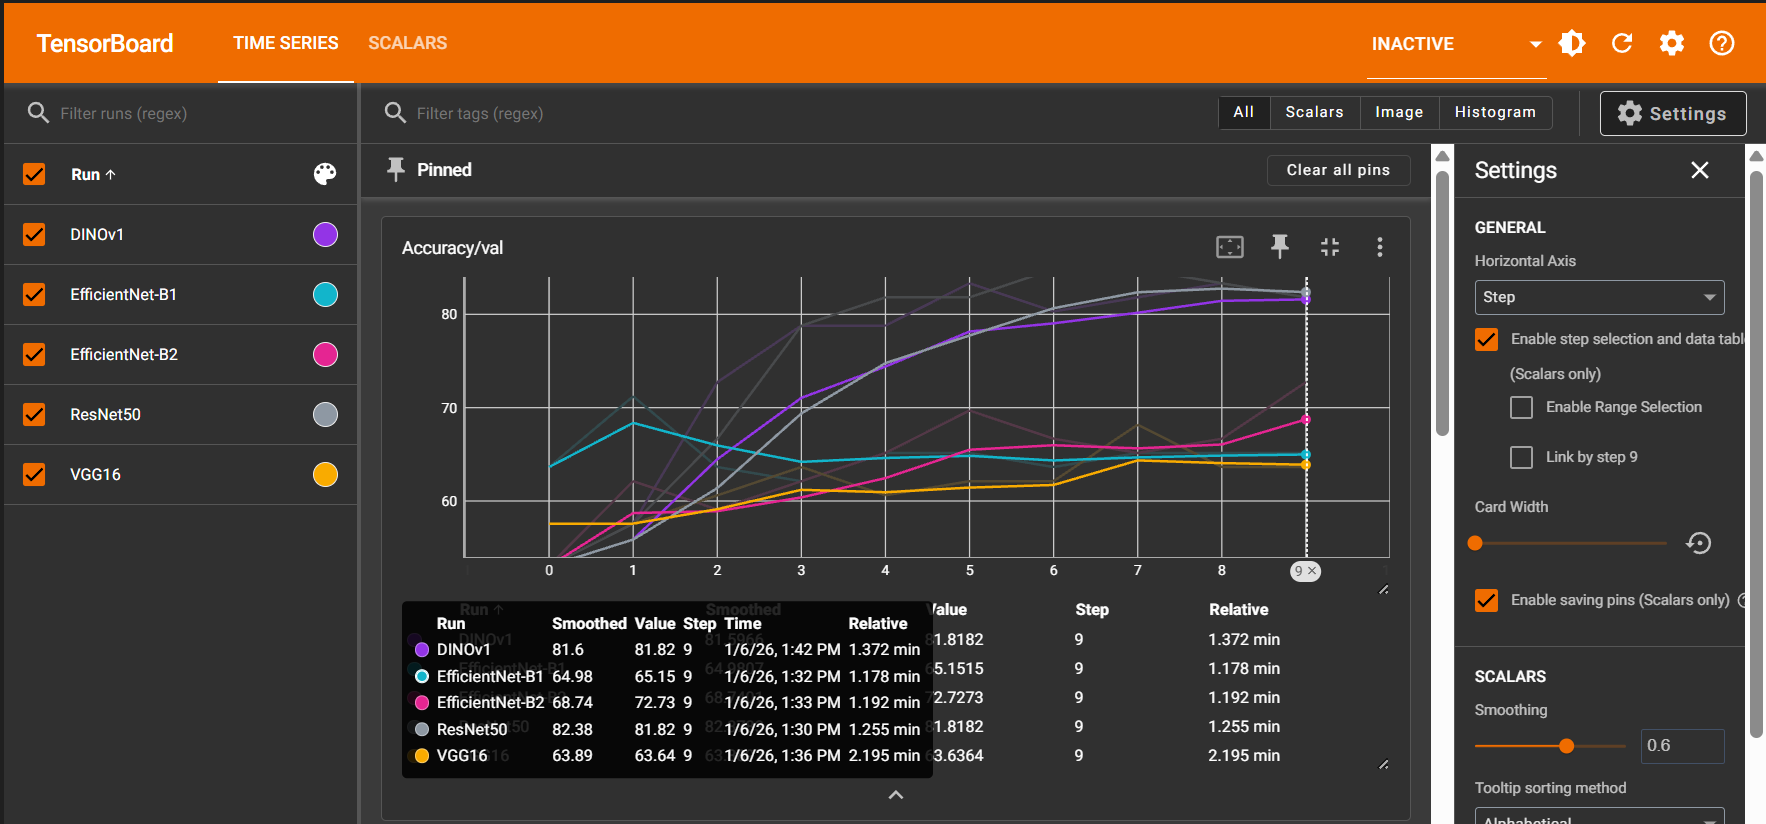